In [18]:
import os
import sys
import numpy
import json
import subprocess
import isambard_dev
import matplotlib.pyplot as plt
%matplotlib notebook

Import modules to get methods for interaction analysis

In [19]:
new_module = "/home/ba13026/mpmodeling/analysis/"
if new_module not in sys.path:
    sys.path.append(new_module)

In [20]:
from insert2db_interactions import get_OH_atoms
from insert2db_interactions import get_KIHs
# from insert2db_interactions import get_COM_bb_distance
from insert2db_interactions import interaction_direction
import json

In [21]:
def get_assembly_radius(file, rtype):
    try:
        # Convert to AMPAL
        p = isambard_dev.ampal.convert_pdb_to_ampal(file)
        # Number of chains
        n_chains = len(p.sequences)
        # Extract Complex and Chain COM data 
        if rtype == 'bb':
            ccom = p.backbone.centre_of_mass
            chains_com = [p[k].backbone.centre_of_mass for k in range(n_chains)]
        elif rtype == 'all' :
            ccom = p.centre_of_mass
            chains_com = [p[k].centre_of_mass for k in range(n_chains)]
        com_dd_distances = []
        for k in range(n_chains):
                com_dd_distances.append(numpy.linalg.norm(chains_com[k] - ccom))
        return com_dd_distances
#         return json.dumps(com_dd_distances)
    except:
        return 'NoFile'

<h2 style="text-align:center">Repetion of interactions analysis for narrow/wide <em>cWza</em> models</h2>

1. Find backbone-assembly radii values ($r_{BB}$) for all models,

2. Filter out those models with mean narrow and wide radii, within a common standard deviation,
> Check identity is identical with currently analysed models

3. Find H-bonds and KIHs for these models; make sure no *spurious protons* are added,

4. See whether any noticeable difference appears between narrow and wide groups,

5. Compare with current results

6. Visualise location of H-bonds and KIHs in PDB. VMD shots.

**1. Find backbone-assembly radii values (rBB) for all models**

In [5]:
path0 = "/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis/"

In [6]:
r_bb_data = []
r_bbsc_data = []
for i in range(1000):
    pdb = path0+'/input/'+'refined1_0001_INPUT_'+format(i+1,'04d')+'_ignorechain'+'.pdb'
    r_bb_data.append(numpy.mean(get_assembly_radius(pdb,'bb')))
    r_bbsc_data.append(numpy.mean(get_assembly_radius(pdb,'all')))

Saved radial data in JSON file

In [8]:
with open(path0+'/'+'md_relax'+'/'+'BB-Assembly_Radii_Docked.json', 'w') as fp:
    json.dump(r_bb_data, fp)

<IPython.core.display.Javascript object>


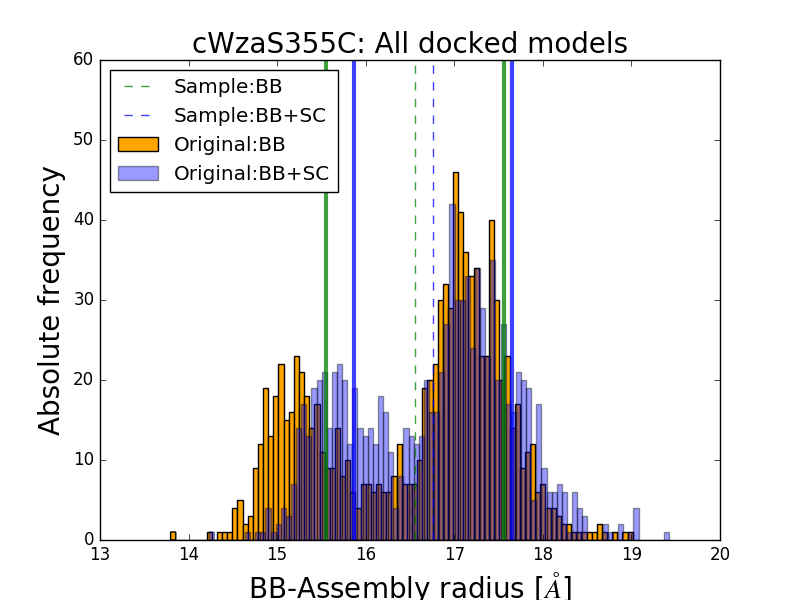

In [11]:
com_hist = plt.figure(dpi=100)

###################### BACKBONE ####################################
r_data = r_bb_data
plt.hist(r_data,bins=90,color='orange',label='Original:BB')

# Find meand and std of bb-assembly radius
mean_r = numpy.mean(r_data)
std = numpy.std(r_data)

plt.plot((mean_r-std,mean_r-std),(0,60),linestyle="-",linewidth=3,color="green",alpha=0.75)
plt.plot((mean_r,mean_r),(0,60),linestyle="--",linewidth=1,color="green",alpha=0.75,label="Sample:BB")
plt.plot((mean_r+std,mean_r+std),(0,60),linestyle="-",linewidth=3,color="green",alpha=0.75)
###################### BACKBONE and SIDECHAINS ####################################
r_data = r_bbsc_data
plt.hist(r_data,bins=90,color='blue',label='Original:BB+SC',alpha=0.4)

# Find meand and std of bb-assembly radius
mean_r = numpy.mean(r_data)
std = numpy.std(r_data)

plt.plot((mean_r-std,mean_r-std),(0,60),linestyle="-",linewidth=3,color="blue",alpha=0.75)
plt.plot((mean_r,mean_r),(0,60),linestyle="--",linewidth=1,color="blue",alpha=0.75,label="Sample:BB+SC")
plt.plot((mean_r+std,mean_r+std),(0,60),linestyle="-",linewidth=3,color="blue",alpha=0.75)
########################################################################
plt.title("cWzaS355C: All docked models",fontsize=20)
plt.xlabel("BB-Assembly radius [$\AA$]",fontsize=20)
plt.ylabel("Absolute frequency",fontsize=20)

plt.legend(loc='best')
plt.show()

In [12]:
print('Average and STD BB-Assembly radius: ', numpy.mean(r_bb_data), numpy.std(r_bb_data))
print('Average and STD BB+SC-Assembly radius: ', numpy.mean(r_bbsc_data), numpy.std(r_bbsc_data))

Average and STD BB-Assembly radius:  16.5536399391 1.00214095976
Average and STD BB+SC-Assembly radius:  16.7565844446 0.890987826662


**2. Find all models corresponding to the samples of models**

In [ ]:
# Sample for Narrow/Wide models
models = []
for i in range(1000):
    d = r_bb_data[i]
    if (mean_rbb-std) < d < (mean_rbb+std):
        models.append(format(i+1,'04d'))

Number of models

In [ ]:
len(models)

**<span style="color:red">TO-DO's</span>**

1. Generate ABchain PDBs and renumber residues. Use for interaction analysis
2. Get statistics of H-bonds and KIHs for initial mixed sample
3. Split sample by conductance (low/high) and repeat statistics of interactions for separate samples
4. Compare results with cWza docked models ... Depending on results, perform EM for selected models. 

**Create AB chains PDB**

In [13]:
for i in range(1000):
    pdbname = 'refined1_0001_INPUT_'+format(i+1,'04d')+'_ignorechain'+'.pdb'
    pdb = path0+'/input/'+pdbname
    if not os.path.isdir(path0+'/md_relax/ABchains'):
        subprocess.call(['mkdir',path0+'/md_relax/ABchains'])
    else:
        output_pdb = path0+'/md_relax/ABchains/'+pdbname
        !pymol -qc ~/mpmodeling/tools/create_ABchain_pdbs.py -- $pdb $output_pdb

**3. Find H-bonds and KIHs for these models**

**<p style="text-align:center"> H-bonds </p>**

In [15]:
models = [str(format(i+1,'04d')) for i in range(1000)]

In [18]:
S_hbonds = {}
for nmodel in models:
    path_chainAB = path0+'/md_relax/ABchains/'+'refined1_0001_INPUT_'+str(nmodel)+'_ignorechain.pdb'
#     !ls {path_chainAB}
    S_reduced_interactions_model = []
    for x in get_OH_atoms(path_chainAB):
        hb_raw = json.loads(x)
        hb = json.dumps(hb_raw[:-1]+[interaction_direction(hb_raw[-1])])
        S_reduced_interactions_model.append(hb)
    S_hbonds[nmodel] = list(set(S_reduced_interactions_model))

In [19]:
S_hbonds_sample = set()
for s in list(S_hbonds.values()):
    S_hbonds_sample = S_hbonds_sample.union(set(s))

In [20]:
S_hbonds_sample

{'["11", "HG", "12", "OE1", -1]',
 '["11", "HG", "16", "OG1", -1]',
 '["16", "HG1", "7", "OD1", 1]',
 '["18", "HG1", "22", "OD2", -1]',
 '["21", "HD1", "22", "OD1", 0]',
 '["21", "HD1", "22", "OD2", -1]',
 '["21", "HD1", "26", "OG1", -1]',
 '["21", "HE2", "25", "OE2", -1]',
 '["21", "HE2", "26", "OG1", -1]',
 '["21", "HE2", "29", "OH", -1]',
 '["24", "HG1", "28", "NH1", 0]',
 '["26", "HG1", "21", "ND1", 1]',
 '["26", "HG1", "21", "NE2", 1]',
 '["26", "HG1", "25", "OE1", 1]',
 '["26", "HG1", "25", "OE2", 1]',
 '["26", "HG1", "29", "OH", 1]',
 '["28", "HE", "25", "OE1", 0]',
 '["28", "HE", "28", "NH1", -1]',
 '["28", "HE", "32", "OG1", 0]',
 '["29", "HH", "21", "NE2", 1]',
 '["29", "HH", "25", "OE1", 1]',
 '["29", "HH", "25", "OE2", 0]',
 '["32", "HG1", "32", "OXT", 0]',
 '["6", "HE1", "12", "NE2", -1]',
 '["6", "HE1", "12", "OE1", -1]'}

In [21]:
S_hbonds_ordered = []
for resn in range(1,33):
    for hb in S_hbonds_sample:
        x = json.loads(hb)
        if int(x[0]) == resn:
            S_hbonds_ordered.append(json.dumps(x))

In [22]:
S_hbonds_ordered

['["6", "HE1", "12", "NE2", -1]',
 '["6", "HE1", "12", "OE1", -1]',
 '["11", "HG", "12", "OE1", -1]',
 '["11", "HG", "16", "OG1", -1]',
 '["16", "HG1", "7", "OD1", 1]',
 '["18", "HG1", "22", "OD2", -1]',
 '["21", "HD1", "22", "OD1", 0]',
 '["21", "HE2", "26", "OG1", -1]',
 '["21", "HD1", "26", "OG1", -1]',
 '["21", "HE2", "25", "OE2", -1]',
 '["21", "HD1", "22", "OD2", -1]',
 '["21", "HE2", "29", "OH", -1]',
 '["24", "HG1", "28", "NH1", 0]',
 '["26", "HG1", "25", "OE1", 1]',
 '["26", "HG1", "21", "ND1", 1]',
 '["26", "HG1", "25", "OE2", 1]',
 '["26", "HG1", "29", "OH", 1]',
 '["26", "HG1", "21", "NE2", 1]',
 '["28", "HE", "25", "OE1", 0]',
 '["28", "HE", "28", "NH1", -1]',
 '["28", "HE", "32", "OG1", 0]',
 '["29", "HH", "25", "OE1", 1]',
 '["29", "HH", "21", "NE2", 1]',
 '["29", "HH", "25", "OE2", 0]',
 '["32", "HG1", "32", "OXT", 0]']

In [23]:
Hbonds_stats_sample = {}
for nmodel in models:
    hbonds_model = S_hbonds[str(nmodel)]
    # Define OH-atom type decomposition vector
    shb_vector = []
    for shb in S_hbonds_ordered:
        c = 0
        for hb in hbonds_model:
            if hb == shb:
                c+=1
        shb_vector.append(c)
    Hbonds_stats_sample[nmodel] = shb_vector

**<p style="text-align:center"> KIHs </p>**

In [24]:
S_kihs = {}
for nmodel in models:
    path_chainAB = path0+'/md_relax/ABchains/refined1_0001_INPUT_'+str(nmodel)+'_ignorechain.pdb'
    #!ls {path_chainAB}
    S_kihs[nmodel] = []
    for x in get_KIHs(path_chainAB):
        kih_raw = json.loads(x)
        kih = json.dumps(kih_raw[:-1]+[interaction_direction(kih_raw[-1])])
        S_kihs[nmodel].append(kih)

In [25]:
S_kihs_sample = set()
for s in list(S_kihs.values()):
    S_kihs_sample = S_kihs_sample.union(set(s))

In [26]:
S_kihs_sample

{'["10", "16", "19", "20", "23", -1]',
 '["11", "12", "13", "15", "16", -1]',
 '["12", "1", "3", "4", "7", 1]',
 '["12", "3", "4", "7", "10", 1]',
 '["12", "3", "4", "7", "11", 1]',
 '["16", "10", "11", "14", "15", 1]',
 '["16", "10", "14", "11", "7", 1]',
 '["16", "10", "14", "15", "18", 1]',
 '["16", "10", "14", "17", "18", 1]',
 '["16", "14", "10", "15", "11", 1]',
 '["16", "14", "11", "10", "15", 1]',
 '["16", "14", "15", "11", "10", 1]',
 '["16", "15", "14", "18", "11", 1]',
 '["16", "3", "6", "7", "10", 1]',
 '["17", "19", "22", "23", "26", -1]',
 '["18", "16", "19", "20", "23", -1]',
 '["19", "6", "10", "14", "17", 1]',
 '["2", "4", "7", "8", "11", -1]',
 '["21", "19", "22", "23", "26", -1]',
 '["21", "22", "23", "25", "26", -1]',
 '["21", "22", "25", "26", "29", -1]',
 '["22", "14", "17", "18", "21", 1]',
 '["23", "14", "17", "18", "21", 1]',
 '["23", "18", "21", "22", "25", 1]',
 '["23", "21", "22", "25", "28", 1]',
 '["23", "21", "24", "25", "28", 1]',
 '["25", "23", "26", "2

In [27]:
S_kihs_ordered = []
for resn in range(1,33):
    for kih in S_kihs_sample:
        x = json.loads(kih)
        if int(x[0]) == resn:
            S_kihs_ordered.append(json.dumps(x))

In [28]:
S_kihs_ordered

['["2", "4", "7", "8", "11", -1]',
 '["6", "10", "11", "14", "15", -1]',
 '["7", "12", "13", "15", "16", -1]',
 '["9", "1", "3", "4", "7", 1]',
 '["10", "16", "19", "20", "23", -1]',
 '["11", "12", "13", "15", "16", -1]',
 '["12", "3", "4", "7", "11", 1]',
 '["12", "1", "3", "4", "7", 1]',
 '["12", "3", "4", "7", "10", 1]',
 '["16", "10", "14", "11", "7", 1]',
 '["16", "14", "10", "15", "11", 1]',
 '["16", "14", "15", "11", "10", 1]',
 '["16", "15", "14", "18", "11", 1]',
 '["16", "3", "6", "7", "10", 1]',
 '["16", "10", "14", "17", "18", 1]',
 '["16", "10", "11", "14", "15", 1]',
 '["16", "10", "14", "15", "18", 1]',
 '["16", "14", "11", "10", "15", 1]',
 '["17", "19", "22", "23", "26", -1]',
 '["18", "16", "19", "20", "23", -1]',
 '["19", "6", "10", "14", "17", 1]',
 '["21", "22", "23", "25", "26", -1]',
 '["21", "22", "25", "26", "29", -1]',
 '["21", "19", "22", "23", "26", -1]',
 '["22", "14", "17", "18", "21", 1]',
 '["23", "18", "21", "22", "25", 1]',
 '["23", "21", "22", "25", "

In [29]:
KIHs_stats_sample = {}
for nmodel in models:
    kihs_model = S_kihs[str(nmodel)]
    skih_vector = []
    for skih in S_kihs_ordered:
        c = 0
        for kih in kihs_model:
            if kih == skih:
                c+=1
        skih_vector.append(c)
    KIHs_stats_sample[nmodel] = skih_vector

All plotted data

<IPython.core.display.Javascript object>


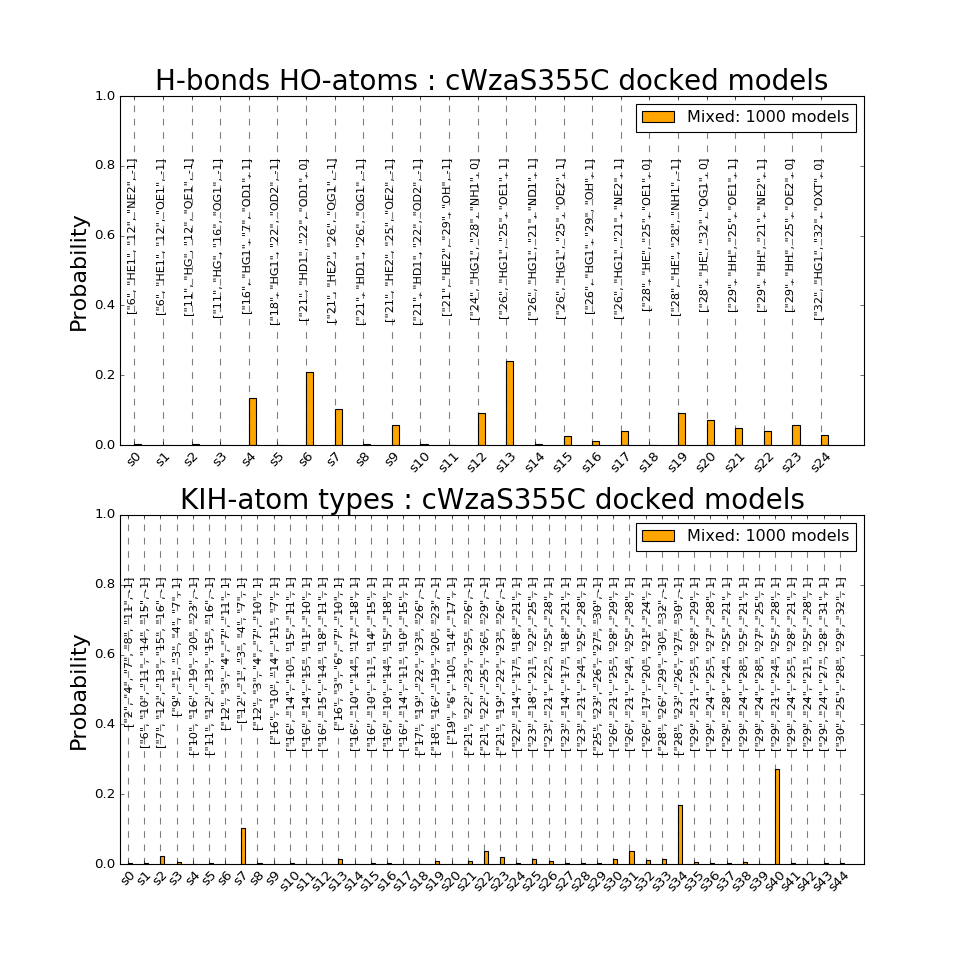

In [36]:
fig_hb_sample, ax = plt.subplots(2,1,figsize=(12,12))
################################################################
S = S_hbonds_ordered

X = numpy.zeros(len(S))
N = 0
for pdb in list(Hbonds_stats_sample.keys()):
    x = Hbonds_stats_sample[pdb]
    X = X + numpy.asarray(x)
    N += 1
        
ax[0].bar(numpy.arange(len(S)),X/1000,color="orange",width=0.25,label="Mixed: "+str(N)+" models")

ax[0].set_xlim(-0.5,len(S)+0.5)
ax[0].set_ylim(0,1)

ax[0].set_xticks(range(len(S)))
ax[0].set_xticklabels(["s"+str(i) for i in range(len(S))],rotation=45)
for i in range(len(S)):
    ax[0].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[0].set_ylabel("Probability",fontsize=20)
    
for i in range(len(S)):
    ax[0].text(i-0.25,0.8,list(S)[i],fontsize=10,rotation=90)

ax[0].set_title("H-bonds HO-atoms : cWzaS355C docked models",fontsize=25)
ax[0].legend(loc='best')
################################################################
S = S_kihs_ordered

X = numpy.zeros(len(S))
N = 0
for pdb in list(KIHs_stats_sample.keys()):
    x = KIHs_stats_sample[pdb]
    X = X + numpy.asarray(x)
    N += 1

ax[1].bar(numpy.arange(len(S)),X/1000,color="orange",width=0.25,label="Mixed: "+str(N)+" models")

ax[1].set_xlim(-0.5,len(S)+0.5)
ax[1].set_ylim(0,1)

ax[1].set_xticks(range(len(S)))
ax[1].set_xticklabels(["s"+str(i) for i in range(len(S))],rotation=45)
for i in range(len(S)):
    ax[1].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[1].set_ylabel("Probability",fontsize=20)
    
for i in range(len(S)):
    ax[1].text(i-0.25,0.8,list(S)[i],fontsize=10,rotation=90)

ax[1].set_title("KIH-atom types : cWzaS355C docked models",fontsize=25)
ax[1].legend(loc='best')

plt.show()

<h1 style="text-align:center">Sampling by conductance and BB-assembly radius</h1>

Functions for data filtering

In [37]:
def rm_none(data):
    return [x for x in data if x!='None']

In [38]:
def filter_missing_data(data):
    x,y = data
    N = len(data[0])
    X = []; Y = []
    for n in range(N):
        try:
            a = x[n]
        except:
            a = 'None'
        try:
            b = y[n]
        except:
            b = 'None'
        if (a != 'None') and (b != 'None'):
            X.append(float(a))
            Y.append(float(b))
    return [X,Y]

In [39]:
from scipy.stats import gaussian_kde

def density_estimation(m1,m2):
    xmin=min(m1)
    xmax=max(m1)
    ymin=min(m2)
    ymax=max(m2)
    X, Y = numpy.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = numpy.vstack([X.ravel(), Y.ravel()])                                                       
    values = numpy.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = numpy.reshape(kernel(positions).T, X.shape)
    return X,Y,Z

In [40]:
def weights4hist(data):
    return numpy.ones_like(data)/float(len(data))

Stuff for database data extraction

In [41]:
new_module = "/home/ba13026/mpmodeling/"
if new_module not in sys.path:
    sys.path.append(new_module)

In [42]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from setup_db import Json, Pdb, SuperHelix_Parameters, Conformation, BUDE_Energies \
,RosettaMP_Energies, Interhelix_Interactions, HOLE_Output, SASA_Estimates, Base

In [99]:
dbfile = path0+'/'+'refined1_8chains.db'

In [100]:
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker()
DBSession.bind = engine
session = DBSession()

**Get HOLE data from previously generated database**

In [103]:
model_ids = []
for i in range(1000):
    try:
        mid = session.query(Pdb.id).filter_by(
            pdb_name='input2/refined1_0001_INPUT_'+str(format(i+1,'04d'))+'_ignorechain.pdb' ).first()
        model_ids.append(mid[0])
    except:
        model_ids.append('NoFile')

Gpred_Rmin_all = []
for id in model_ids:
    try:
        model_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
        Gpred_Rmin_all.append(model_Gpred_Rmin[0])
    except:
        Gpred_Rmin_all.append(-1)

Get contourplot data for $r_{BB}$ and `estimated conductance` ...

In [104]:
# X,Y = filter_missing_data([r_bb_data,Gpred_Rmin_all])
X,Y = r_bb_data,Gpred_Rmin_all
datacontour = list(density_estimation(X,Y))

In [105]:
XX,YY,ZZ = datacontour

In [108]:
from sklearn.cluster import KMeans
XY = numpy.array([r_bb_data, Gpred_Rmin_all]).T
kmeans = KMeans(n_clusters=2, random_state=0).fit(XY)
# kmeans.labels_
kmeans.cluster_centers_

array([[ 17.20540408,   0.94052323],
       [ 15.31074089,   0.91213629]])

In [119]:
from sklearn.mixture import GMM
import pandas as pd

<IPython.core.display.Javascript object>


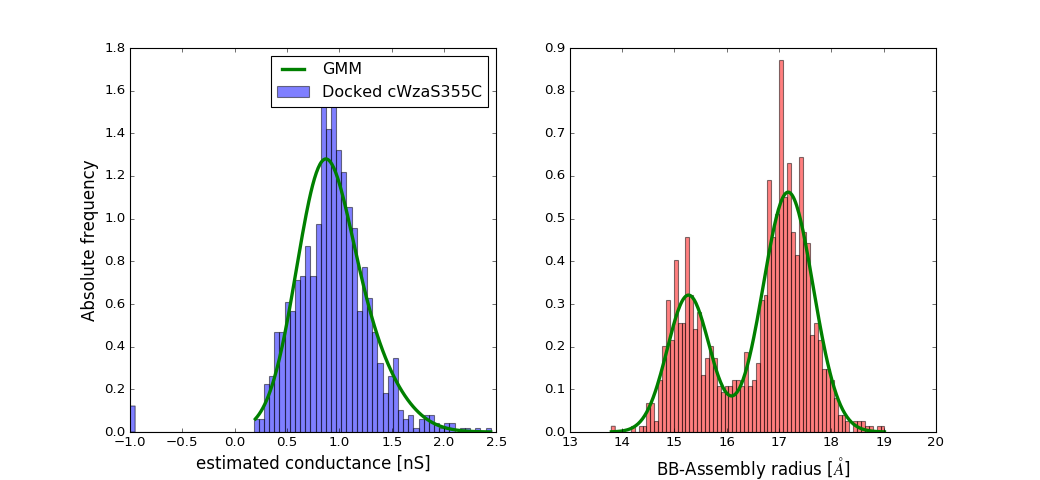

<IPython.core.display.Javascript object>


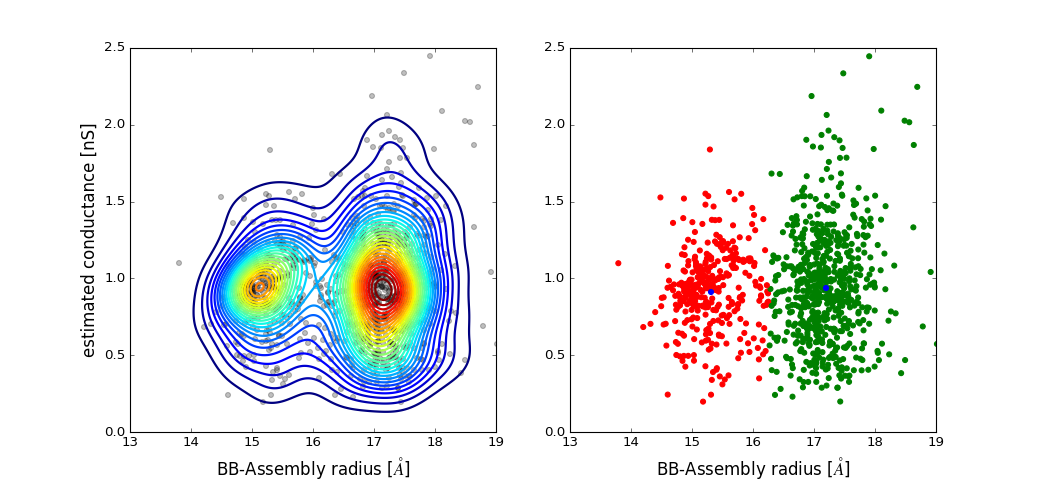

In [120]:
G_hist, ax1 = plt.subplots(1,2,figsize=(13,6))

model_name = "cWzaS355C"
##############################################################
ax1[0].hist(Gpred_Rmin_all,bins=70,normed=True,label="Docked "+model_name,alpha=0.5)

indata = [x for x in Gpred_Rmin_all if x!=-1]
n_modes = 2
gmm = GMM(n_components=n_modes)
gmm = gmm.fit(X=numpy.expand_dims(indata,1))
gmm_x = numpy.linspace(numpy.asarray(indata).min(),numpy.asarray(indata).max(),256)
data = gmm.score_samples(gmm_x.reshape(-1,1))
gmm_y = numpy.exp(data[0])

ax1[0].plot(gmm_x, gmm_y, color="green", lw=3, label="GMM")
####################################################### PANDAS STUFF
a = gmm.means_.reshape(-1)
b = gmm.weights_.reshape(-1)
c = gmm.covars_.reshape(-1)
stats_gmm = sorted(numpy.array([a,b,c]).T, key=lambda x:x[0], reverse=False)
units = "nS"
data_types = ["$\mu$","$\sigma$","Amplitude"]
modes_labels = ["Mode "+str(i) for i in range(n_modes)]
df_g_pred = pd.DataFrame(stats_gmm,index=modes_labels,columns=data_types)
##############################################################
ax1[0].set_xlabel("estimated conductance [nS]",fontsize="15")
ax1[0].set_ylabel("Absolute frequency",fontsize=15)
# ax1[0].set_ylim(0,100)
##############################################################
ax1[1].hist(r_bb_data,bins=70,color="red",normed=True,alpha=0.5)

indata = r_bb_data
n_modes = 2
gmm = GMM(n_components=n_modes)
gmm = gmm.fit(X=numpy.expand_dims(indata,1))
gmm_x = numpy.linspace(numpy.asarray(indata).min(),numpy.asarray(indata).max(),256)
data = gmm.score_samples(gmm_x.reshape(-1,1))
gmm_y = numpy.exp(data[0])

ax1[1].plot(gmm_x, gmm_y, color="green", lw=3, label="GMM")
####################################################### PANDAS STUFF
a = gmm.means_.reshape(-1)
b = gmm.weights_.reshape(-1)
c = gmm.covars_.reshape(-1)
stats_gmm = sorted(numpy.array([a,b,c]).T, key=lambda x:x[0], reverse=False)
units = "A"
data_types = ["$\mu$","$\sigma$","Amplitude"]
modes_labels = ["Mode "+str(i) for i in range(n_modes)]
df_r_bb = pd.DataFrame(stats_gmm,index=modes_labels,columns=data_types)
##############################################################
ax1[1].set_xlabel("BB-Assembly radius [$\AA$]",fontsize=15)

ax1[0].legend(loc="best")
#################################################################
cmaps, ax2 = plt.subplots(1,2,figsize=(13,6))

ax2[0].scatter(X,Y,color="black",alpha=0.25)
ax2[0].contour(XX,YY,ZZ,30,linewidths=2)
#################################################################
ax2[0].set_xlim(13,19)
ax2[0].set_ylim(0,2.5)
ax2[0].set_xlabel("BB-Assembly radius [$\AA$]",fontsize=15)
ax2[0].set_ylabel("estimated conductance [nS]",fontsize=15)
#################################################################
from matplotlib import colors
cmap = colors.ListedColormap(['green','red'])

ax2[1].scatter(X,Y,color=cmap(list(kmeans.labels_)))
for x in kmeans.cluster_centers_:
    ax2[1].scatter(x[0],x[1],color="blue",s=20)
#################################################################
ax2[1].set_xlim(13,19)
ax2[1].set_ylim(0,2.5)
ax2[1].set_xlabel("BB-Assembly radius [$\AA$]",fontsize=15)
#################################################################b
plt.show()

In [121]:
df_g_pred

,$\mu$,$\sigma$,Amplitude
Mode 0,0.823487,0.56873,0.062655
Mode 1,1.099244,0.43127,0.130985


In [122]:
df_r_bb

,$\mu$,$\sigma$,Amplitude
Mode 0,15.270217,0.32622,0.164707
Mode 1,17.175026,0.67378,0.228642


<h1 style="text-align:center">Model sampling</h1>

**Identify remaining narrow/wide models**

In [144]:
# Parameters for filtering
g_m = 0.823487; g_std = 0.56873
r0_m = 15.270217; r0_std = 0.32622
r1_m = 17.175026; r1_std = 0.67378
fg = 1; fr = 0.5
# Lists of narrow/wide models
models_narrow_bb = []
models_wide_bb = []

for i in range(1000):
    g = Gpred_Rmin_all[i]
    if (g != -1) and (abs(g - g_m) <= fg*g_std):
        if abs(r_bb_data[i] - r0_m) <= 4*fr*r0_std:
            models_narrow_bb.append(format(i+1,'04d'))
        elif abs(r_bb_data[i] - r1_m) <= fr*r1_std:
            models_wide_bb.append(format(i+1,'04d'))

In [145]:
print("Number of narrow models (G ~ 1st mode): ", len(models_narrow_bb))
print("Number of wide models (G ~ 1st mode): ", len(models_wide_bb))

Number of narrow models (G ~ 1st mode):  277
Number of wide models (G ~ 1st mode):  338


All narrow and wide models

In [146]:
pdbs_all = {}
for model_type in ['narrow','wide']:
    pdbs_all[model_type] = []
    if model_type == 'narrow':
        pdb_modeln = models_narrow_bb
    elif model_type == 'wide':
        pdb_modeln = models_wide_bb
    for nmodel in pdb_modeln:
        pdbs_all[model_type].append("refined1_0001_INPUT_"+nmodel+"_ignorechain.pdb")

In [147]:
from operator import itemgetter

<IPython.core.display.Javascript object>


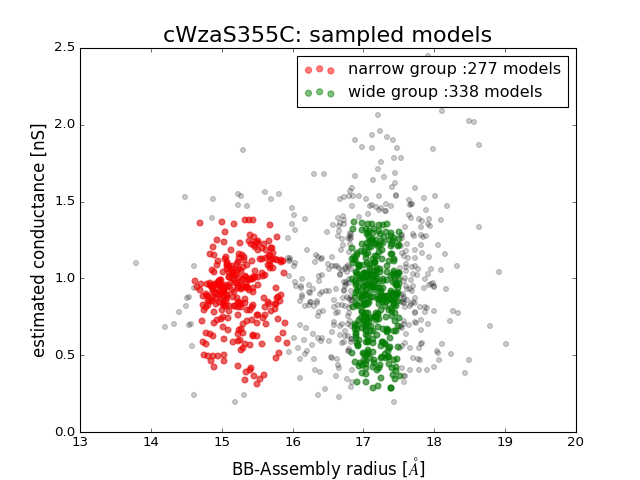

In [152]:
fig_check = plt.figure()

model_name = "cWzaS355C"
plt.scatter(r_bb_data, Gpred_Rmin_all,color='black',alpha=0.2)

colors = ['red','green']
c=0
for model_type in ['narrow','wide']:
    if model_type == 'narrow':
        models = models_narrow_bb
    elif model_type == 'wide':
        models = models_wide_bb
    indeces = [int(idx)-1 for idx in models]
    X = list(itemgetter(*indeces)(r_bb_data))
    Y = list(itemgetter(*indeces)(Gpred_Rmin_all))
    plt.scatter(X,Y,color=colors[c],s=30,alpha=0.5,label=model_type+' group :'+str(len(models))+' models')
    c+=1

plt.title(model_name+": sampled models",fontsize=20)
plt.xlabel("BB-Assembly radius [$\AA$]",fontsize=15)
plt.ylabel("estimated conductance [nS]",fontsize=15)
plt.ylim(0,2.5)

plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


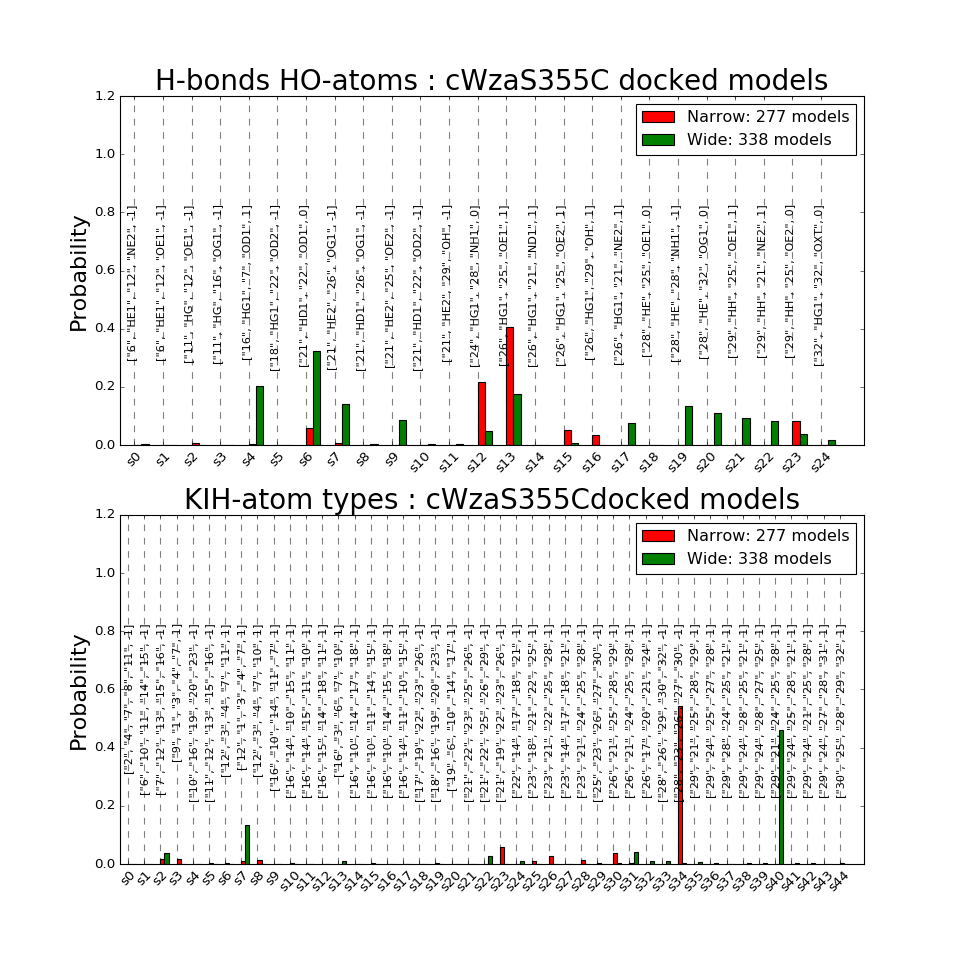

In [153]:
fig_hb_sample, ax = plt.subplots(2,1,figsize=(12,12))
model_name="cWzaS355C"
################################################################
S = S_hbonds_ordered
########################################################################
X = numpy.zeros(len(S))
N = 0
for pdb in models_narrow_bb:
    x = Hbonds_stats_sample[pdb]
    X = X + numpy.asarray(x)
    N += 1
        
ax[0].bar(numpy.arange(len(S)),X/float(N),color="red",width=0.25,label="Narrow: "+str(N)+" models")

X = numpy.zeros(len(S))
N = 0
for pdb in models_wide_bb:
    x = Hbonds_stats_sample[pdb]
    X = X + numpy.asarray(x)
    N += 1

ax[0].bar(numpy.arange(len(S))+0.25,X/float(N),color="green",width=0.25,label="Wide: "+str(N)+" models")
########################################################################


ax[0].set_xlim(-0.5,len(S)+0.5)
ax[0].set_ylim(0,1.2)

ax[0].set_xticks(range(len(S)))
ax[0].set_xticklabels(["s"+str(i) for i in range(len(S))],rotation=45)
for i in range(len(S)):
    ax[0].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[0].set_ylabel("Probability",fontsize=20)
    
for i in range(len(S)):
    ax[0].text(i-0.25,0.8,list(S)[i],fontsize=10,rotation=90)

ax[0].set_title("H-bonds HO-atoms : "+model_name+" docked models",fontsize=25)
ax[0].legend(loc='best')
################################################################
S = S_kihs_ordered
########################################################################
X = numpy.zeros(len(S))
N = 0
for pdb in models_narrow_bb:
    x = KIHs_stats_sample[pdb]
    X = X + numpy.asarray(x)
    N += 1

ax[1].bar(numpy.arange(len(S)),X/float(N),color="red",width=0.25,label="Narrow: "+str(N)+" models")

X = numpy.zeros(len(S))
N = 0
for pdb in models_wide_bb:
    x = KIHs_stats_sample[pdb]
    X = X + numpy.asarray(x)
    N += 1

ax[1].bar(numpy.arange(len(S))+0.25,X/float(N),color="green",width=0.25,label="Wide: "+str(N)+" models")

########################################################################
ax[1].set_xlim(-0.5,len(S)+0.5)
ax[1].set_ylim(0,1.2)

ax[1].set_xticks(range(len(S)))
ax[1].set_xticklabels(["s"+str(i) for i in range(len(S))],rotation=45)
for i in range(len(S)):
    ax[1].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[1].set_ylabel("Probability",fontsize=20)
    
for i in range(len(S)):
    ax[1].text(i-0.25,0.8,list(S)[i],fontsize=10,rotation=90)

ax[1].set_title("KIH-atom types : "+model_name+"docked models",fontsize=25)
ax[1].legend(loc='best')

plt.show()

## Embedding and EM of all models

In [154]:
import subprocess

In [8]:
path0 = "/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis"

In [158]:
directory = path0+'/md_relax/narrow'
if not os.path.isdir(directory):
    subprocess.call(['mkdir',directory])
    
directory = path0+'/md_relax/narrow/input'
if not os.path.isdir(directory):
    subprocess.call(['mkdir',directory])    

directory = path0+'/md_relax/narrow/output'
if not os.path.isdir(directory):
    subprocess.call(['mkdir',directory])
#############################################    
directory = path0+'/md_relax/wide'
if not os.path.isdir(directory):
    subprocess.call(['mkdir',directory])
    
directory = path0+'/md_relax/wide/input'
if not os.path.isdir(directory):
    subprocess.call(['mkdir',directory])    

directory = path0+'/md_relax/wide/output'
if not os.path.isdir(directory):
    subprocess.call(['mkdir',directory])

Copy all sample models to `input` subfolder in the corresponding group folder.

In [171]:
for group in ['narrow','wide']:
    if group == 'narrow':
        models_bb = models_narrow_bb
    elif group == 'wide':
        models_bb = models_wide_bb
    for modeln in models_bb:
        pdbname = 'refined1_0001_INPUT_'+str(modeln)+'_ignorechain'
        pdb_path = path0+'/input/'+pdbname+'.pdb'
        destiny = path0+'/md_relax/'+group+'/input/'+pdbname+'.pdb'
        !pymol -qc ~/mpmodeling/tools/renumber_chains.py -- $pdb_path $destiny

Make list of pdbs per group for MD preparation, embedding, and resolvation.

In [9]:
for group in ['narrow','wide']:
    if group == 'narrow':
        models_bb = models_narrow_bb
    elif group == 'wide':
        models_bb = models_wide_bb
    pdblist = open(path0+'/md_relax/'+group+'_pdbs.txt', 'w')
    for modeln in models_bb:
        pdbname = 'refined1_0001_INPUT_'+str(modeln)+'_ignorechain.pdb'
        pdblist.write(pdbname+'\n')
    pdblist.close()

NameError: name 'models_narrow_bb' is not defined

In [10]:
path0

'/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis'

In [11]:
models_narrow_bb = []
models_wide_bb = []
for group in ['narrow','wide']:
    lines = open(path0+'/md_relax/'+group+'_pdbs.txt','r').readlines()
    if group == 'narrow':
        models_bb = models_narrow_bb
    elif group == 'wide':
        models_bb = models_wide_bb
    for l in lines:
        models_bb.append(l.split("_")[3])

#### 1. Extract all post-EM protein PDBs

In [12]:
# Working directory path
path0="/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis/md_relax"
import os
counter = 0
for group in ['narrow','wide']:
    # Define list of model numbers per group
    if group == 'narrow':
        models_bb = models_narrow_bb
    elif group == 'wide':
        models_bb = models_wide_bb
    for modeln in models_bb:
        pdbname = 'refined1_0001_INPUT_'+str(modeln)+'_ignorechain'
        gro_path = path0+'/'+group+'/output/'+pdbname+'/complex/em/em_20000stps.gro'
        if not os.path.isfile(gro_path):
            print(group, pdbname)
            counter += 1
print("%s models couldn't be energy minimized."%counter)
print("Total number of models: ",len(models_narrow_bb)+len(models_wide_bb))
print("EM efficiency: ",1-counter/(len(models_narrow_bb)+len(models_wide_bb)))

narrow refined1_0001_INPUT_0014_ignorechain
narrow refined1_0001_INPUT_0026_ignorechain
narrow refined1_0001_INPUT_0047_ignorechain
narrow refined1_0001_INPUT_0073_ignorechain
narrow refined1_0001_INPUT_0081_ignorechain
narrow refined1_0001_INPUT_0111_ignorechain
narrow refined1_0001_INPUT_0112_ignorechain
narrow refined1_0001_INPUT_0194_ignorechain
narrow refined1_0001_INPUT_0207_ignorechain
narrow refined1_0001_INPUT_0213_ignorechain
narrow refined1_0001_INPUT_0219_ignorechain
narrow refined1_0001_INPUT_0221_ignorechain
narrow refined1_0001_INPUT_0234_ignorechain
narrow refined1_0001_INPUT_0239_ignorechain
narrow refined1_0001_INPUT_0240_ignorechain
narrow refined1_0001_INPUT_0285_ignorechain
narrow refined1_0001_INPUT_0292_ignorechain
narrow refined1_0001_INPUT_0299_ignorechain
narrow refined1_0001_INPUT_0302_ignorechain
narrow refined1_0001_INPUT_0429_ignorechain
narrow refined1_0001_INPUT_0495_ignorechain
narrow refined1_0001_INPUT_0543_ignorechain
narrow refined1_0001_INPUT_0553_

Extract protein structures for EM models

In [ ]:
# Working directory path

import os
counter = 0
for group in ['narrow','wide']:
    # Define list of model numbers per group
    if group == 'narrow':
        models_bb = models_narrow_bb
    elif group == 'wide':
        models_bb = models_wide_bb
    for modeln in models_bb:
        pdbname = 'refined1_0001_INPUT_'+str(modeln)+'_ignorechain'
        gro_path = path0+'/'+group+'/output/'+pdbname+'/complex/em/em_20000stps'
        if os.path.isfile(gro_path+'.gro') and not os.path.isfile(gro_path+'_Protein.pdb'):
            !bash ~/mpmodeling/protocols/sem/gro2pdb.sh {gro_path}.gro 

GROMACS:    gmx make_ndx, VERSION 5.0.6

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or

In [14]:
# Working directory path

import os
counter = 0
for group in ['narrow','wide']:
    # Define list of model numbers per group
    if group == 'narrow':
        models_bb = models_narrow_bb
    elif group == 'wide':
        models_bb = models_wide_bb
    for modeln in models_bb:
        pdbname = 'refined1_0001_INPUT_'+str(modeln)+'_ignorechain'
        gro_path = path0+'/'+group+'/output/'+pdbname+'/complex/em/em_No-PR_Ubonds'
        if os.path.isfile(gro_path+'.gro') and not os.path.isfile(gro_path+'_Protein.pdb'):
            #print(group, pdbname)
            counter += 1
print("%s Post-EM protein structures have not been extracted."%counter)

0 Post-EM protein structures have not been extracted.


In [16]:
# Extract of post-EM protein PDBs (No-PR, Unconstrained bonds)
postEM_ppdbs = {}
for group in ['narrow','wide']:
    # Define list of model numbers per group
    if group == 'narrow':
        models_bb = models_narrow_bb
    elif group == 'wide':
        models_bb = models_wide_bb
    postEM_ppdbs[group] = {}
    for modeln in models_bb:
        pdbname = 'refined1_0001_INPUT_'+str(modeln)+'_ignorechain'
        ppdb_path = path0+'/'+group+'/output/'+pdbname+'/complex/em/em_20000stps_Protein.pdb'
        if os.path.isfile(ppdb_path):
            postEM_ppdbs[group][pdbname] = ppdb_path
        else:
            postEM_ppdbs[group][pdbname] = 'NoFile'

In [17]:
postEM_ppdbs['narrow']

{'refined1_0001_INPUT_0001_ignorechain': '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis/md_relax/narrow/output/refined1_0001_INPUT_0001_ignorechain/complex/em/em_20000stps_Protein.pdb',
 'refined1_0001_INPUT_0010_ignorechain': '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis/md_relax/narrow/output/refined1_0001_INPUT_0010_ignorechain/complex/em/em_20000stps_Protein.pdb',
 'refined1_0001_INPUT_0011_ignorechain': '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis/md_relax/narrow/output/refined1_0001_INPUT_0011_ignorechain/complex/em/em_20000stps_Protein.pdb',
 'refined1_0001_INPUT_0014_ignorechain': 'NoFile',
 'refined1_0001_INPUT_0015_ignorechain': '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzas355c_NoWPN/3-analysis/md_relax/narrow/output/refined1_0001_INPUT_0015_ignorechain/complex/em/em_20000stps_Protein.pdb',
 'refined1_0001_INPUT_002

#### 2. Find all H-bonds and KIHs: original and post-EM models, for narrow and wide models

In [22]:
from insert2db_interactions import get_OH_atoms
from insert2db_interactions import get_KIHs
from insert2db_interactions import interaction_direction
import json

In [23]:
def find_interactions(pdb):
    hbonds_data = [json.loads(hb) for hb in get_OH_atoms(pdb)]
    pdb_hbonds = [json.dumps(hb[:-1]+[hb[-1]]) for hb in hbonds_data]
    # KIHs data
    kihs_data = [json.loads(kih) for kih in get_KIHs(pdb)]
    pdb_kihs = [json.dumps(kih[:-1]+[kih[-1]]) for kih in kihs_data]
    return pdb_hbonds, pdb_kihs

In [24]:
Hbonds_data = {}
KIHs_data = {}
for group in ["narrow", "wide"]:
    # Define pdbname space and paths to post-EM pdbs
    pdbnames = list(postEM_ppdbs[group].keys())
    Hbonds_data[group] = {}
    KIHs_data[group] = {}
    for pdb in pdbnames:
        Hbonds_data[group][pdb] = {}
        KIHs_data[group][pdb] = {}
        # Find interactions for originally docked model
        pdb_original = path0+"/"+group+"/input/"+pdb+".pdb"
        pdb_hbonds, pdb_kihs = find_interactions(pdb_original)
        # Find interactions for post-EM docked model
        pdb_postEM = postEM_ppdbs[group][pdb]
        if pdb_postEM != 'NoFile':
            hbonds_postEM, kihs_postEM = find_interactions(pdb_postEM)
            # Store data in dic
            Hbonds_data[group][pdb] = {"original":pdb_hbonds, "em":hbonds_postEM}
            KIHs_data[group][pdb] = {"original":pdb_kihs, "em":kihs_postEM}
        else:
            Hbonds_data[group][pdb] = {"original":pdb_hbonds, "em":"NoFile"}
            KIHs_data[group][pdb] = {"original":pdb_kihs, "em":"NoFile"}

In [25]:
with open(path0+'/'+'Hbonds_Original_PostEM.json', 'w') as fp:
    json.dump(Hbonds_data, fp)

In [26]:
with open(path0+'/'+'KIHs_Original_PostEM.json', 'w') as fp:
    json.dump(KIHs_data, fp)

<span style="color:red">MAKE DATABASE OF BB-RAD, HOLE G, HBONDS AND KIHS</span>

#### 3. Find base sets of OH-atom types and KIHs

Get all H-bonds and KIHs identities, then reduce by defining their direction in the assembly.

In [27]:
S_hbonds = set()
for group in ["wide","narrow"]:
    for pdb in list(Hbonds_data[group].keys()):
        data0 = Hbonds_data[group][pdb]
        for type in ["original","em"]:
            data1 = data0[type]
            if data1 != "NoFile":
                S_hbonds = S_hbonds.union(set(data1))

In [28]:
S_kihs = set()
for group in ["wide","narrow"]:
    for pdb in list(KIHs_data[group].keys()):
        data0 = KIHs_data[group][pdb]
        for type in ["original","em"]:
            data1 = data0[type]
            if data1 != "NoFile":
                S_kihs = S_kihs.union(set(data1))

In [29]:
S_hbonds = set([json.dumps(x[:-1]+[interaction_direction(x[-1])]) for x in [json.loads(x) for x in list(S_hbonds)]])
S_kihs = set([json.dumps(x[:-1]+[interaction_direction(x[-1])]) for x in [json.loads(x) for x in list(S_kihs)]])

In [30]:
S_hbonds_ordered = []
for resn in range(1,33):
    for hb in S_hbonds:
        x = json.loads(hb)
        if int(x[0]) == resn:
            S_hbonds_ordered.append(json.dumps(x))

In [31]:
S_kihs_ordered = []
for resn in range(1,33):
    for kih in S_kihs:
        x = json.loads(kih)
        if int(x[0]) == resn:
            S_kihs_ordered.append(json.dumps(x))

In [32]:
S_hbonds = S_hbonds_ordered
S_kihs = S_kihs_ordered

In [33]:
S_hbonds

['["1", "H2", "12", "OE1", -1]',
 '["1", "H2", "5", "NH1", 0]',
 '["1", "H2", "5", "NH2", 0]',
 '["5", "HE", "12", "OE1", -1]',
 '["6", "HE1", "12", "NE2", -1]',
 '["6", "HE1", "12", "OE1", -1]',
 '["6", "HE1", "5", "NH2", 0]',
 '["11", "HG", "7", "OD1", 0]',
 '["11", "HG", "7", "ND2", 0]',
 '["11", "HG", "12", "NE2", 0]',
 '["11", "HG", "12", "OE1", -1]',
 '["11", "HG", "12", "N", 0]',
 '["16", "HG1", "7", "ND2", 1]',
 '["16", "HG1", "7", "OD1", 1]',
 '["18", "HG1", "22", "OD1", -1]',
 '["18", "HG1", "22", "OD2", -1]',
 '["21", "HE2", "29", "OH", -1]',
 '["21", "HD1", "22", "OD1", -1]',
 '["21", "HD1", "28", "NH1", 0]',
 '["21", "HE2", "25", "OE2", -1]',
 '["21", "HD1", "25", "OE2", 0]',
 '["21", "HE2", "25", "OE1", 0]',
 '["21", "HE2", "25", "OE2", 0]',
 '["21", "HD1", "24", "OG1", 0]',
 '["21", "HE2", "23", "N", -1]',
 '["21", "HE2", "25", "OE1", -1]',
 '["21", "HD1", "22", "OD2", 0]',
 '["21", "HD1", "29", "OH", -1]',
 '["21", "HE2", "26", "OG1", -1]',
 '["21", "HD1", "22", "OD1", 

In [35]:
S_kihs_ordered

['["3", "9", "12", "13", "16", -1]',
 '["6", "12", "15", "16", "19", -1]',
 '["6", "11", "14", "15", "18", -1]',
 '["7", "9", "12", "13", "16", -1]',
 '["7", "12", "13", "15", "16", -1]',
 '["7", "9", "12", "13", "15", -1]',
 '["9", "1", "3", "4", "7", 1]',
 '["11", "12", "13", "15", "16", -1]',
 '["11", "1", "2", "3", "6", 1]',
 '["11", "3", "2", "5", "1", 1]',
 '["12", "1", "3", "4", "7", 1]',
 '["12", "4", "7", "8", "11", 1]',
 '["12", "7", "4", "3", "1", 1]',
 '["12", "3", "4", "7", "11", 1]',
 '["12", "3", "4", "7", "10", 1]',
 '["13", "3", "7", "10", "11", 1]',
 '["13", "3", "6", "7", "10", 1]',
 '["14", "15", "16", "19", "20", -1]',
 '["15", "10", "11", "14", "15", 1]',
 '["15", "7", "10", "11", "14", 1]',
 '["15", "3", "6", "7", "10", 1]',
 '["16", "10", "11", "14", "15", 1]',
 '["16", "3", "7", "10", "14", 1]',
 '["16", "10", "14", "15", "18", 1]',
 '["16", "10", "14", "17", "18", 1]',
 '["16", "14", "10", "15", "11", 1]',
 '["16", "15", "14", "10", "11", 1]',
 '["16", "14", "

#### 4. Find average interaction multiplicity per conformation group

In [34]:
Hbonds_stats = {}

for group in ["narrow","wide"]:
    pdbnames = list(postEM_ppdbs[group].keys())
    Hbonds_stats[group] = {}
    for pdb in pdbnames:
        Hbonds_stats[group][pdb] = {}
        hbonds_model = Hbonds_data[group][pdb]
        if hbonds_model["em"] != "NoFile":
            for model_type in ["original","em"]:
                shb_vector = []
                for shb in S_hbonds:
                    c = 0
                    for x in hbonds_model[model_type]:
                        hb_raw = json.loads(x)
                        hb = json.dumps(hb_raw[:-1]+[interaction_direction(hb_raw[-1])])
                        if hb == shb:
                            c+=1
                    shb_vector.append(c)
                Hbonds_stats[group][pdb][model_type] = shb_vector    
        else:
            for model_type in ["original","em"]:
                Hbonds_stats[group][pdb][model_type] = "NA"

In [ ]:
fig_hb_new, ax = plt.subplots(2,1,figsize=(16,12))

################################################################
X = numpy.zeros(len(S_hbonds))
Y = numpy.zeros(len(S_hbonds))
N_models = 0
for pdb in list(Hbonds_stats["narrow"].keys()):
    x = Hbonds_stats["narrow"][pdb]
    if x["em"]!="NA":
        X = X + numpy.asarray(x["original"])
        Y = Y + numpy.asarray(x["em"])
        N_models += 1

ax[0].bar(numpy.arange(len(S_hbonds))+0.25,X/float(8*N_models),color="blue",width=0.25,label="Original: "+str(N_narrow)+" models")
ax[0].bar(numpy.arange(len(S_hbonds)),Y/float(8*N_models),color="red",width=0.25,label="post-EM: "+str(N_narrow)+" models")

ax[0].set_xlim(-0.5,len(S_hbonds)+0.5)
ax[0].set_ylim(0,1.2)

ax[0].set_xticks(range(len(S_hbonds)))
ax[0].set_xticklabels(["s"+str(i) for i in range(len(S_hbonds))],rotation=45)
for i in range(len(S_hbonds)):
    ax[0].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[0].set_ylabel("Probability",fontsize=20)
    
for i in range(len(S_hbonds)):
    ax[0].text(i-0.25,0.8,list(S_hbonds)[i],fontsize=10,rotation=90)

ax[0].set_title("H-bonds HO-atoms : cWza narrow",fontsize=25)
################################################################
X = numpy.zeros(len(S_hbonds))
Y = numpy.zeros(len(S_hbonds))
N_models = 0
for pdb in list(Hbonds_stats["wide"].keys()):
    x = Hbonds_stats["wide"][pdb]
    if x["em"]!="NA":
        X = X + numpy.asarray(x["original"])
        Y = Y + numpy.asarray(x["em"])
        N_models += 1

ax[1].bar(numpy.arange(len(S_hbonds))+0.25,X/float(8*N_models),color="blue",width=0.25,label="Original: "+str(N_wide)+" models")
ax[1].bar(numpy.arange(len(S_hbonds)),Y/float(8*N_models),color="red",width=0.25,label="post-EM: "+str(N_wide)+" models")

ax[1].set_xlim(-0.5,len(S_hbonds)+0.5)
ax[1].set_ylim(0,1.2)

ax[1].set_xlabel("HO-pair type",fontsize=20)
ax[1].set_xticks(range(len(S_hbonds)))
ax[1].set_xticklabels(["s"+str(i) for i in range(len(S_hbonds))],rotation=45)
for i in range(len(S_hbonds)):
    ax[1].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[1].set_ylabel("Probability",fontsize=20)

for i in range(len(S_hbonds)):
    ax[1].text(i-0.25,0.8,list(S_hbonds)[i],fontsize=10,rotation=90)

ax[1].set_title("H-bonds HO-atoms : cWzaS355C wide",fontsize=25)
################################################################

ax[0].legend(loc="upper center")
ax[1].legend(loc="upper center")
plt.show()

In [ ]:
fig_hb_comparison_new, ax = plt.subplots(2,1,figsize=(16,12))

################################################################
X = numpy.zeros(len(S_hbonds))
N_narrow = 0
for pdb in list(Hbonds_stats["narrow"].keys()):
    x = Hbonds_stats["narrow"][pdb]
    if x["em"]!="NA":
        X = X + numpy.asarray(x["original"])
        N_narrow += 1

Y = numpy.zeros(len(S_hbonds))
N_wide = 0
for pdb in list(Hbonds_stats["wide"].keys()):
    x = Hbonds_stats["wide"][pdb]
    if x["em"]!="NA":
        Y = Y + numpy.asarray(x["original"])
        N_wide += 1
        
ax[0].bar(numpy.arange(len(S_hbonds))+0.25,X/float(8*N_narrow),color="red",width=0.25,label="Original: Narrow: "+str(N_narrow)+" models")
ax[0].bar(numpy.arange(len(S_hbonds)),Y/float(8*N_wide),color="green",width=0.25,label="Original: Wide: "+str(N_wide)+" models")

ax[0].set_xlim(-0.5,len(S_hbonds)+0.5)
ax[0].set_ylim(0,1.2)

ax[0].set_xticks(range(len(S_hbonds)))
ax[0].set_xticklabels(["s"+str(i) for i in range(len(S_hbonds))],rotation=45)
for i in range(len(S_hbonds)):
    ax[0].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[0].set_ylabel("Probability",fontsize=20)
    
for i in range(len(S_hbonds)):
    ax[0].text(i-0.25,0.8,list(S_hbonds)[i],fontsize=10,rotation=90)

ax[0].set_title("H-bonds HO-atoms : cWza",fontsize=25)
################################################################
X = numpy.zeros(len(S_hbonds))
N_narrow = 0
for pdb in list(Hbonds_stats["narrow"].keys()):
    x = Hbonds_stats["narrow"][pdb]
    if x["em"]!="NA":
        X = X + numpy.asarray(x["em"])
        N_narrow += 1

Y = numpy.zeros(len(S_hbonds))
N_wide = 0
for pdb in list(Hbonds_stats["wide"].keys()):
    x = Hbonds_stats["wide"][pdb]
    if x["em"]!="NA":
        Y = Y + numpy.asarray(x["em"])
        N_wide += 1

ax[1].bar(numpy.arange(len(S_hbonds))+0.25,X/float(8*N_narrow),color="red",width=0.25,label="post-EM: Narrow: "+str(N_narrow)+" models")
ax[1].bar(numpy.arange(len(S_hbonds)),Y/float(8*N_wide),color="green",width=0.25,label="post-EM: Wide: "+str(N_wide)+" models")

ax[1].set_xlim(-0.5,len(S_hbonds)+0.5)
ax[1].set_ylim(0,1.2)

ax[1].set_xlabel("HO-pair type",fontsize=20)
ax[1].set_xticks(range(len(S_hbonds)))
ax[1].set_xticklabels(["s"+str(i) for i in range(len(S_hbonds))],rotation=45)
for i in range(len(S_hbonds)):
    ax[1].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[1].set_ylabel("Probability",fontsize=20)

for i in range(len(S_hbonds)):
    ax[1].text(i-0.25,0.8,list(S_hbonds)[i],fontsize=10,rotation=90)

################################################################

ax[0].legend(loc="upper center")
ax[1].legend(loc="upper center")
plt.show()

KIHs

In [ ]:
KIHs_stats = {}

for group in ["narrow","wide"]:
    pdbnames = list(postEM_ppdbs[group].keys())
    KIHs_stats[group] = {}
    for pdb in pdbnames:
        KIHs_stats[group][pdb] = {}
        kihs_model = KIHs_data[group][pdb]
        if kihs_model["em"] != "NoFile":
            for model_type in ["original","em"]:
                skih_vector = []
                for skih in S_kihs:
                    c = 0
                    for x in kihs_model[model_type]:
                        kih_raw = json.loads(x)
                        kih = json.dumps(kih_raw[:-1]+[interaction_direction(kih_raw[-1])])
                        if kih == skih:
                            c+=1
                    skih_vector.append(c)
                KIHs_stats[group][pdb][model_type] = skih_vector    
        else:
            for model_type in ["original","em"]:
                KIHs_stats[group][pdb][model_type] = "NA"

In [ ]:
fig_kih_original_new, ax = plt.subplots(2,1,figsize=(22,12))
################################################################
S = S_kihs
X = numpy.zeros(len(S))
Y = numpy.zeros(len(S))
N_models = 0
for pdb in list(KIHs_stats["narrow"].keys()):
    x = KIHs_stats["narrow"][pdb]
    if x["em"]!="NA":
        X = X + numpy.asarray(x["original"])
        Y = Y + numpy.asarray(x["em"])
        N_models += 1
        
ax[0].bar(numpy.arange(len(S))+0.25,X/float(8*N_models),color="blue",width=0.25,label="Original: "+str(N_models)+" models")
ax[0].bar(numpy.arange(len(S)),Y/float(8*N_models),color="red",width=0.25,label="post-EM: "+str(N_models)+" models")

ax[0].set_xlim(-0.5,len(S)+0.5)
ax[0].set_ylim(0,1.2)

ax[0].set_xticks(range(len(S_kihs)))
ax[0].set_xticklabels(["s"+str(i) for i in range(len(S_kihs))],rotation=45)
for i in range(len(S_kihs)):
    ax[0].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[0].set_ylabel("Probability",fontsize=20)

for i in range(len(S)):
    ax[0].text(i-0.25,0.8,list(S)[i],fontsize=10,rotation=90)

ax[0].set_title("KIH atom groups : cWza narrow",fontsize=25)
################################################################
X = numpy.zeros(len(S))
Y = numpy.zeros(len(S))
N_models = 0
for pdb in list(KIHs_stats["wide"].keys()):
    x = KIHs_stats["wide"][pdb]
    if x["em"]!="NA":
        X = X + numpy.asarray(x["original"])
        Y = Y + numpy.asarray(x["em"])
        N_models += 1
        
ax[1].bar(numpy.arange(len(S))+0.25,X/float(8*N_models),color="blue",width=0.25,label="Original: "+str(N_models)+" models")
ax[1].bar(numpy.arange(len(S)),Y/float(8*N_models),color="red",width=0.25,label="post-EM: "+str(N_models)+" models")

ax[1].set_xlim(-0.5,len(S)+0.5)
ax[1].set_ylim(0,1.2)

ax[1].set_xlabel("KIH type",fontsize=20)
ax[1].set_xticks(range(len(S_kihs)))
ax[1].set_xticklabels(["s"+str(i) for i in range(len(S_kihs))],rotation=45)
for i in range(len(S_kihs)):
    ax[1].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[1].set_ylabel("Probability",fontsize=20)

for i in range(len(S)):
    ax[1].text(i-0.25,0.8,list(S)[i],fontsize=10,rotation=90)

ax[1].set_title("KIH atom groups : cWza wide",fontsize=25)
################################################################

ax[0].legend(loc="upper center")
ax[1].legend(loc="upper center")
plt.show()

In [ ]:
fig_kih_original_new, ax = plt.subplots(2,1,figsize=(22,12))
################################################################
S = S_kihs
X = numpy.zeros(len(S))
N_narrow = 0
for pdb in list(KIHs_stats["narrow"].keys()):
    x = KIHs_stats["narrow"][pdb]
    if x["em"]!="NA":
        X = X + numpy.asarray(x["original"])
        N_narrow += 1

Y = numpy.zeros(len(S))
N_wide = 0
for pdb in list(KIHs_stats["wide"].keys()):
    x = KIHs_stats["wide"][pdb]
    if x["em"]!="NA":
        Y = Y + numpy.asarray(x["original"])
        N_wide += 1
        
ax[0].bar(numpy.arange(len(S))+0.25,X/float(8*N_narrow),color="red",width=0.25,label="Original: Narrow: "+str(N_narrow)+" models")
ax[0].bar(numpy.arange(len(S)),Y/float(8*N_wide),color="green",width=0.25,label="Original: Wide: "+str(N_wide)+" models")

ax[0].set_xlim(-0.5,len(S)+0.5)
ax[0].set_ylim(0,1.2)

ax[0].set_xticks(range(len(S_kihs)))
ax[0].set_xticklabels(["s"+str(i) for i in range(len(S_kihs))],rotation=45)
for i in range(len(S_kihs)):
    ax[0].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[0].set_ylabel("Probability",fontsize=20)

for i in range(len(S)):
    ax[0].text(i-0.25,0.8,list(S)[i],fontsize=10,rotation=90)

ax[0].set_title("KIH atom groups : cWza",fontsize=25)
################################################################
X = numpy.zeros(len(S))
N_narrow = 0
for pdb in list(KIHs_stats["narrow"].keys()):
    x = KIHs_stats["narrow"][pdb]
    if x["em"]!="NA":
        X = X + numpy.asarray(x["em"])
        N_narrow += 1

Y = numpy.zeros(len(S))
N_wide = 0
for pdb in list(KIHs_stats["wide"].keys()):
    x = KIHs_stats["wide"][pdb]
    if x["em"]!="NA":
        Y = Y + numpy.asarray(x["em"])
        N_wide += 1
        
ax[1].bar(numpy.arange(len(S))+0.25,X/float(8*N_models),color="red",width=0.25,label="post-EM: Narrow: "+str(N_narrow)+" models")
ax[1].bar(numpy.arange(len(S)),Y/float(8*N_models),color="green",width=0.25,label="post-EM: Wide: "+str(N_wide)+" models")

ax[1].set_xlim(-0.5,len(S)+0.5)
ax[1].set_ylim(0,1.2)

ax[1].set_xlabel("KIH type",fontsize=20)
ax[1].set_xticks(range(len(S_kihs)))
ax[1].set_xticklabels(["s"+str(i) for i in range(len(S_kihs))],rotation=45)
for i in range(len(S_kihs)):
    ax[1].plot((i,i),(0,1.2),color="black",linestyle="--",alpha=0.5)

ax[1].set_ylabel("Probability",fontsize=20)

for i in range(len(S)):
    ax[1].text(i-0.25,0.8,list(S)[i],fontsize=10,rotation=90)

################################################################

ax[0].legend(loc="upper center")
ax[1].legend(loc="upper center")
plt.show()

**To-do's**

1. Take screenshots of structures showing key H-bonds and KIHs that differentiate narrow and wide groups

... Setup DB for analysis (Go through previous scripts)

2. Repeat analysis for cWzaK375C

3. Submit PRMD cWza sims (PR-SC+BB) for MD (100ns), GPU ... Determine times and resources needed for simulation and analysis.

3. Make slides explaining overall protocol for analysis. Clean Jupyter notebooks

4. Write functions for analysis and order libraries in common location (~/mpmodeling/protocol/analysis or tools)



In [ ]:
/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/cwzak375c_NoWPN/3-analysis